In [18]:
import matplotlib.font_manager
import numpy as np
from qutip_qtrl import fidcomp
from qutip import *

import matplotlib.pyplot as plt
import matplotlib
matplotlib.font_manager.fontManager.addfont("fonts/ipag.ttf")
matplotlib.rcParams['font.family'] = 'IPAGothic'

final cost   : 2.375e-08


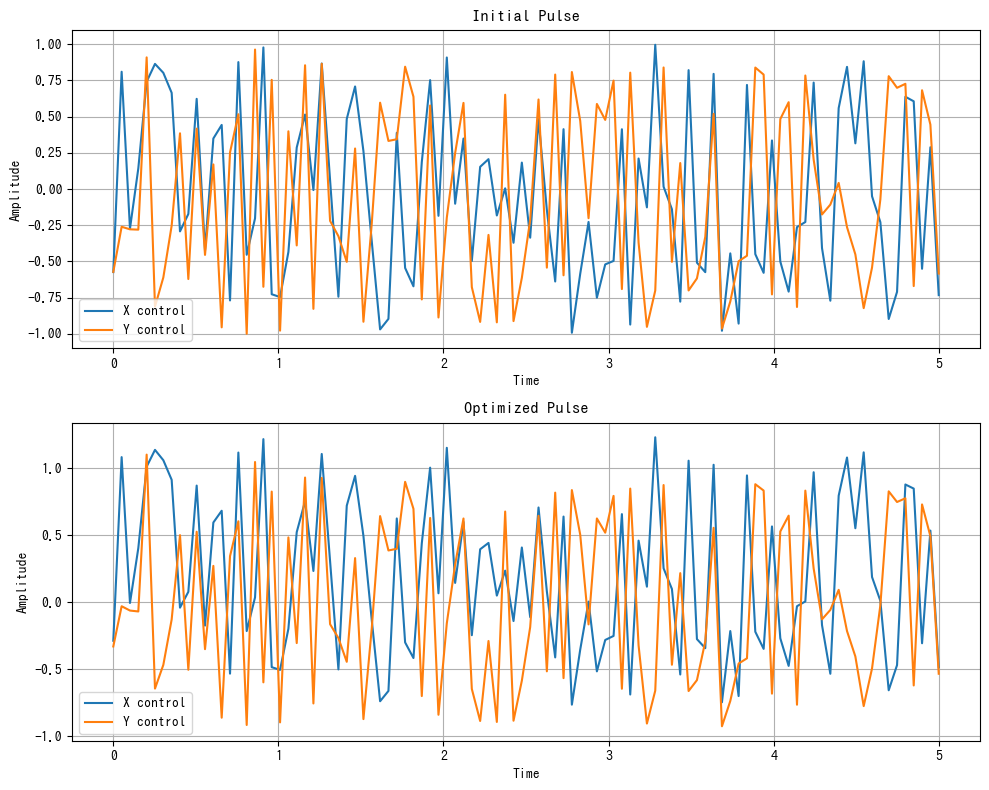

In [22]:
from qutip import identity, sigmax, sigmay, basis, sigmaz
from qutip_qtrl import pulseoptim

H_d = 0 * sigmaz()
H_c = [sigmax(), sigmay()]
U_0 = identity(2)
U_target = sigmax().expm()

n_ts, evo_time = 100, 5.0

init_amps = np.random.uniform(-1, 1, size=(n_ts, len(H_c)))

# --- Optimizer を生成（fid_type はダミーで OK） -----------------------
optim = pulseoptim.create_pulse_optimizer(
    H_d, H_c, U_0, U_target,
    num_tslots=n_ts, evo_time=evo_time,
    fid_type='TRACEDIFF',        # FidCompTraceDiffを使用
    amp_lbound=-5.0, amp_ubound=5.0,
    max_iter=500,
    fid_err_targ=1e-5,
    min_grad=1e-5,
    init_pulse_params=init_amps
)

# --- 最適化実行 -------------------------------------------------------
optim.dynamics.initialize_controls(init_amps)
result = optim.run_optimization()

print(f'final cost   : {result.fid_err:.3e}')  # 最終コスト

# --- 最適化前後のパルスを比較プロット -----------------------------------

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
t = np.linspace(0, evo_time, n_ts)

# 初期パルス
ax1.plot(t, init_amps[:, 0], label='X control')
ax1.plot(t, init_amps[:, 1], label='Y control')
ax1.set_title('Initial Pulse')
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')
ax1.legend()
ax1.grid(True)

# 最適化後のパルス
optimized_amps = result.final_amps
ax2.plot(t, optimized_amps[:, 0], label='X control')
ax2.plot(t, optimized_amps[:, 1], label='Y control')
ax2.set_title('Optimized Pulse')
ax2.set_xlabel('Time')
ax2.set_ylabel('Amplitude')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [20]:
# ------------------- Step‑0: 問題定義 -------------------
N_TS     = 100         # 時間スライス数
EVO_TIME = 5.0         # ゲート長
H_d      = 0.5 * sigmaz()
H_c      = [sigmax()]  # 1 制御
psi0     = basis(2, 0)
psi_tgt  = (basis(2, 0) + basis(2, 1)).unit()

# ------------------- Step‑1: Dynamics だけ作成 -------------
dyn = pulseoptim.create_pulse_optimizer(
    H_d, H_c, U_0, U_target,
    num_tslots=N_TS, evo_time=EVO_TIME,
    fid_type='TRACEDIFF',
    max_iter=500,
    fid_err_targ=1e-2,
    min_grad=1e-5,
    init_pulse_params=init_amps
)

# ------------------- Step‑2: 評価関数を差し替え ------------
from qutip.control.fidcomp import UnitaryFidComp

class MyFid(UnitaryFidComp):          # fid_error = 1-F にした例
    def compute_fid_err_grad(self):
        fid = self.get_fidelity()      # ←親クラスの forward/backward を使用
        grad = -self.grad_fidelity     # F と同時に計算済み
        return 1-fid, grad

dyn.fid_computer = MyFid(dyn)

# ------------------- Step‑3: SciPy に投げる -----------------
import numpy as np
from scipy.optimize import minimize

# x : 1D ベクトル <-> dyn.ctrl_amps : (N_TS, n_ctrls)
def fun_grad(x):
    dyn.update_ctrl_amps(x.reshape(dyn.ctrl_amps.shape))
    f_err, grad = dyn.fid_computer.compute_fid_err_grad()
    return f_err, grad.ravel()        # SciPy 仕様 (1D)

x0   = dyn.ctrl_amps.ravel()
res  = minimize(fun_grad, x0, jac=True, method='L-BFGS-B',
                options={'maxiter': 200})

print("Infidelity =", res.fun)

ImportError: cannot import name 'UnitaryFidComp' from 'qutip.control.fidcomp' (/root/projects/QOC-Baseline/.venv/lib/python3.10/site-packages/qutip_qtrl/fidcomp.py)

# 開発用ノートブック
ここでは評価関数をカスタムできるGRAPEの実装を目標にしています。後半では勾配の計算の仕方や学習と最適化のルールもカスタムできるようにする予定です。
## カスタム評価関数の実装
フィデリティに加えて、パルエネルギーでペナルティを加えてみる。

- $F_{error} = 1 - \frac{1}{d} \|{Tr(U_{tgt}^{\dagger}U(T))}\|$
- にパルスエネルギー($\Sigma u_{jk}^2$)のペナルティをハイパーパラメータ$\lambda=10^{-2}$で加える

$_{min}J=F_{error}+\lambda E_{pulse}$

In [ ]:
# FidCompTraceDiffApproxを継承
class EnergyWeightedPSU(fidcomp.FidCompTraceDiff):
    l = 1e-3 * 0  # エネルギーペナルティの重み

    # 評価関数のみを上書き
    def get_fid_err(self):
        if not self.fidelity_current:
            dyn = self.parent
            d = dyn.target.shape[0]
            dyn.compute_evolution()
            
            U_T = dyn._fwd_evo[dyn.num_tslots]
            U_T = Qobj(U_T, dims=dyn.target.dims)
            overlap = (dyn.target.dag() * U_T).tr()
            F = abs(overlap) / d
            eps = 1.0 - F


            # パルスエネルギー (制御振幅幅の二乗の時間積分)
            amps = dyn.ctrl_amps
            dt = dyn.tau[0]
            E = dt * np.sum(amps**2)

            self.fid_err = (eps + self.l * E)
            self.fidelity_current = True
            print(f"Fidelity error: {eps}, Energy penalty: {self.l * E}, Total: {self.fid_err}")

        return self.fid_err
    
    # 必須の勾配計算メソッドを実装
    def compute_fid_err_grad(self):
        """実装必須のメソッド: フィデリティエラーの勾配を計算
        フィデリティの勾配に加えて、エネルギーペナルティの勾配も計算します
        """
        # フィデリティエラー計算（親クラスのメソッドを呼び出し）
        fid_err = self.get_fid_err()
        
        # 親クラスのメソッドで勾配計算の基本部分を実行
        grad = super().compute_fid_err_grad()
        
        # エネルギーペナルティの勾配を追加
        dyn = self.parent
        dt = dyn.tau[0]
        amps = dyn.ctrl_amps
        
        # エネルギーの勾配は2*u_jk*dt
        energy_grad = 2 * amps * dt * self.l
        
        # フィデリティの勾配とエネルギーの勾配を合わせる
        total_grad = grad + energy_grad
        
        return total_grad

In [ ]:
# single_qubit_opt.py -------------------------------------------------

# --- 系の定義 ---------------------------------------------------------
H_d   = 0 * sigmax()                  # ドリフト 0 としておく
H_c   = [sigmax(), sigmay()]          # X, Y の 2 制御
U_0   = identity(2)                   # 初期ユニタリ
U_tgt = (-1j * np.pi/4 * sigmay()).expm()   # R_y(π/2)

n_ts, evo_time = 100, 10.0

# --- 初期制御振幅を設定 ----------------------------------------------
init_amps = np.random.uniform(-1, 1, size=(n_ts, len(H_c)))  # 初期振幅を小さく

# --- Optimizer を生成（fid_type はダミーで OK） -----------------------
optim = pulseoptim.create_pulse_optimizer(
    H_d, H_c, U_0, U_tgt,
    num_tslots=n_ts, evo_time=evo_time,
    fid_type='TRACEDIFF',        # FidCompTraceDiffを使用
    amp_lbound=-5.0, amp_ubound=5.0,
    max_iter=100,
    fid_err_targ=1e-2,
    min_grad=1e-5
)

# --- FidelityComputer を差し替え -------------------------------------
dyn = optim.dynamics
dyn.initialize_controls(init_amps)
dyn.fid_computer = EnergyWeightedPSU(dyn)
dyn.fid_computer.init_comp()

# --- 最適化実行 -------------------------------------------------------
result = optim.run_optimization()

print(f'final cost   : {result.fid_err:.3e}')  # 最終コスト
print(f'pulse energy: {np.sum(result.final_amps**2) * dyn.tau[0]:.3e}')  # パルスエネルギー

Fidelity error: -0.15593847206448563, Energy penalty: 0.0, Total: -0.15593847206448563
final cost   : -1.559e-01
pulse energy: 6.328e+00


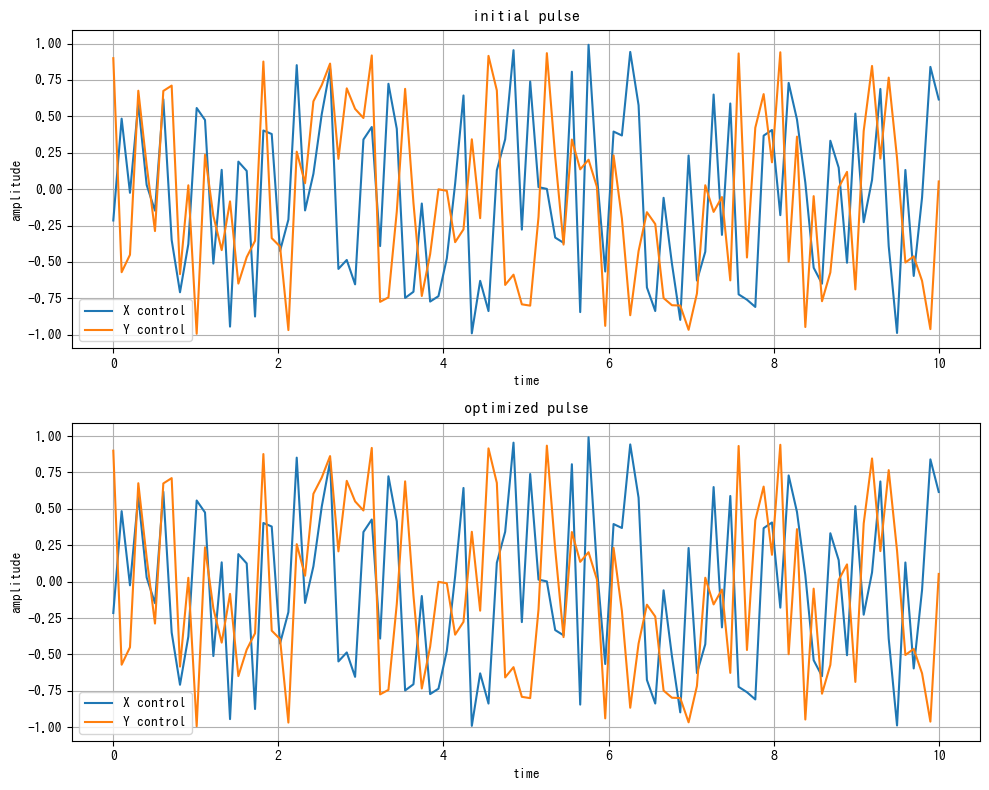

In [ ]:
# --- 最適化前後のパルスを比較プロット -----------------------------------

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
t = np.linspace(0, evo_time, n_ts)

# 初期パルス
ax1.plot(t, init_amps[:, 0], label='X control')
ax1.plot(t, init_amps[:, 1], label='Y control')
ax1.set_title('initial pulse')
ax1.set_xlabel('time')
ax1.set_ylabel('amplitude')
ax1.legend()
ax1.grid(True)

# 最適化後のパルス
optimized_amps = result.final_amps
ax2.plot(t, optimized_amps[:, 0], label='X control')
ax2.plot(t, optimized_amps[:, 1], label='Y control')
ax2.set_title('optimized pulse')
ax2.set_xlabel('time')
ax2.set_ylabel('amplitude')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Custom gradient descent with learning rate
def custom_gradient_descent(dyn, initial_amps, learning_rate=0.1, max_iter=1000, tolerance=1e-9):
    current_amps = initial_amps.copy()
    dyn.update_ctrl_amps(current_amps)
    
    history = []
    
    for i in range(max_iter):
        # Calculate error and gradient
        fid_err = dyn.fid_computer.get_fid_err()
        grad = dyn.fid_computer.compute_fid_err_grad()
        
        # Store history
        history.append({"iteration": i, "fidelity_error": fid_err})
        
        # Check convergence
        if np.max(np.abs(grad)) < tolerance:
            print(f"Converged after {i} iterations")
            break
            
        # Update amplitudes with learning rate
        current_amps -= learning_rate * grad
        
        # Apply bounds if needed
        current_amps = np.clip(current_amps, -5.0, 5.0)
        
        # Update dynamics with new amplitudes
        dyn.update_ctrl_amps(current_amps)
        
        # Clear fidelity computed flag to force recalculation
        dyn.fid_computer.fidelity_current = False
        
        if i % 10 == 0:
            print(f"Iteration {i}, Error: {fid_err:.6e}")
    
    return {
        "final_amps": current_amps,
        "fid_err": dyn.fid_computer.get_fid_err(),
        "history": history,
        "num_iter": i+1
    }

# Use the custom optimizer
result = custom_gradient_descent(dyn, init_amps, learning_rate=0.05)

Iteration 0, Error: -1.559385e-01
Fidelity error: -0.04704003056033956, Energy penalty: 0.0, Total: -0.04704003056033956
Fidelity error: -0.04704003056033956, Energy penalty: 0.0, Total: -0.04704003056033956
Fidelity error: 0.08750347518898727, Energy penalty: 0.0, Total: 0.08750347518898727
Fidelity error: 0.08750347518898727, Energy penalty: 0.0, Total: 0.08750347518898727
Fidelity error: 0.15598061126159446, Energy penalty: 0.0, Total: 0.15598061126159446
Fidelity error: 0.15598061126159446, Energy penalty: 0.0, Total: 0.15598061126159446
Fidelity error: 0.1976100523222123, Energy penalty: 0.0, Total: 0.1976100523222123
Fidelity error: 0.1976100523222123, Energy penalty: 0.0, Total: 0.1976100523222123
Fidelity error: 0.224983904617301, Energy penalty: 0.0, Total: 0.224983904617301
Fidelity error: 0.224983904617301, Energy penalty: 0.0, Total: 0.224983904617301
Iteration 10, Error: 2.249839e-01
Fidelity error: 0.24378365511061084, Energy penalty: 0.0, Total: 0.24378365511061084
Fidel

In [ ]:
from qutip import sigmaz, sigmax, basis, fidelity
from qutip.control import pulseoptim

# ------------------- Step‑0: 問題定義 -------------------
N_TS     = 100         # 時間スライス数
EVO_TIME = 5.0         # ゲート長
H_d      = 0.5 * sigmaz()
H_c      = [sigmax()]  # 1 制御
psi0     = basis(2, 0)
psi_tgt  = (basis(2, 0) + basis(2, 1)).unit()

# ------------------- Step‑1: Dynamics だけ作成 -------------
dyn = pulseoptim.create_pulse_optimizer(
          H_d, H_c, N_TS, EVO_TIME,
          fid_type='GEN',              # 独自コストを後で与える
          phase_option='PSU')

# ------------------- Step‑2: 評価関数を差し替え ------------
from qutip.control.fidcomp import UnitaryFidComp

class MyFid(UnitaryFidComp):          # fid_error = 1-F にした例
    def compute_fid_err_grad(self):
        fid = self.get_fidelity()      # ←親クラスの forward/backward を使用
        grad = -self.grad_fidelity     # F と同時に計算済み
        return 1-fid, grad

dyn.fid_computer = MyFid(dyn)

# ------------------- Step‑3: SciPy に投げる -----------------
import numpy as np
from scipy.optimize import minimize

# x : 1D ベクトル <-> dyn.ctrl_amps : (N_TS, n_ctrls)
def fun_grad(x):
    dyn.update_ctrl_amps(x.reshape(dyn.ctrl_amps.shape))
    f_err, grad = dyn.fid_computer.compute_fid_err_grad()
    return f_err, grad.ravel()        # SciPy 仕様 (1D)

x0   = dyn.ctrl_amps.ravel()
res  = minimize(fun_grad, x0, jac=True, method='L-BFGS-B',
                options={'maxiter': 200})

print("Infidelity =", res.fun)

TypeError: initial must be a Qobj

In [ ]:
# 改善例: 最適化結果の可視化とシミュレーション検証
# 最適化されたパルスの振幅
optimized_amps = res.x.reshape(N_TS, len(H_c))

# パルスの可視化
fig, ax = plt.subplots(figsize=(10, 5))
t = np.linspace(0, EVO_TIME, N_TS)
ax.plot(t, optimized_amps, label='X control')
ax.set_title('最適化されたパルス')
ax.set_xlabel('時間')
ax.set_ylabel('振幅')
ax.grid(True)
ax.legend()
plt.show()

# 最終状態検証
# 時間発展の再計算
dyn.update_ctrl_amps(optimized_amps)
dyn.compute_evolution()

# 初期状態から出発して最終状態を計算
U_final = Qobj(dyn._fwd_evo[N_TS], dims=[[2], [2]])
psi_final = U_final * psi0

# 目標状態との比較
fid_value = fidelity(psi_final, psi_tgt)
print(f"目標状態とのフィデリティ: {fid_value:.8f}")
print(f"初期状態: {psi0}")
print(f"最終状態: {psi_final}")
print(f"目標状態: {psi_tgt}")

# パルスエネルギー計算
pulse_energy = np.sum(optimized_amps**2) * (EVO_TIME/N_TS)
print(f"パルスエネルギー: {pulse_energy:.4e}")

NameError: name 'res' is not defined